In [1]:
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (12,6)

In [2]:
from pandas import read_csv
cases_url = 'https://raw.githubusercontent.com/daenuprobst/covid19-cases-switzerland/master/covid19_cases_switzerland_openzh.csv'
cases = read_csv(cases_url)

os = cases.loc[0,cases.loc[0,:].isnull()].index
cases.loc[0,os] = 0
for i in cases.index.values[1:]:
    os = cases.loc[i,cases.loc[i,:].isnull()].index
    cases.loc[i,os] = cases.loc[i-1,os]
#cases.plot()

In [3]:
from pandas import DataFrame
cantons = list(cases.columns.values)
cantons.remove('Date')
newcases = DataFrame(cases.loc[:,cantons].values[1:] - cases.loc[:,cantons].values[:-1], columns=cantons)
newcases.index = cases.Date.values[1:]
newcases.tail(5)

,AG,AI,AR,BE,BL,BS,FR,GE,GL,GR,...,SO,SZ,TG,TI,UR,VD,VS,ZG,ZH,CH
2020-09-04,27.0,0.0,0.0,26.0,1.0,4.0,34.0,0.0,0.0,0.0,...,3.0,2.0,3.0,5.0,0.0,137.0,12.0,10.0,96.0,373.0
2020-09-05,20.0,0.0,0.0,40.0,4.0,4.0,21.0,0.0,0.0,13.0,...,0.0,4.0,5.0,0.0,0.0,97.0,9.0,0.0,78.0,313.0
2020-09-06,5.0,0.0,0.0,23.0,4.0,4.0,54.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,52.0,2.0,0.0,42.0,199.0
2020-09-07,15.0,0.0,4.0,8.0,0.0,6.0,24.0,0.0,0.0,1.0,...,10.0,8.0,0.0,5.0,1.0,49.0,0.0,6.0,44.0,206.0
2020-09-08,0.0,0.0,0.0,17.0,0.0,7.0,0.0,0.0,0.0,0.0,...,4.0,3.0,3.0,4.0,0.0,0.0,0.0,7.0,0.0,49.0


In [4]:
cantondata = read_csv('cantons.tsv', sep='\t')
cantondata['ratio'] = cantondata.Einwohner/cantondata[cantondata.kz!='CH'].Einwohner.sum()
cantondata = cantondata.set_index('kz')

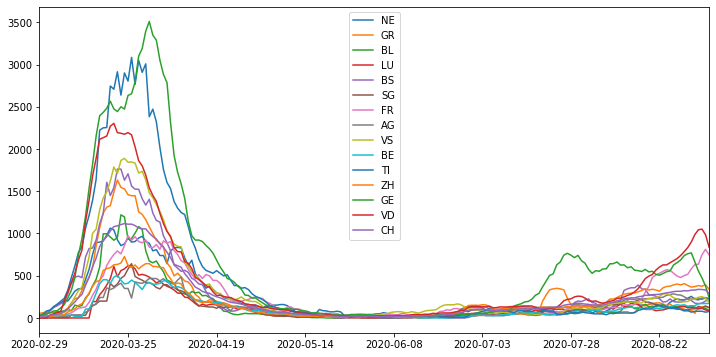

In [5]:
n = 7

ncit = newcases.values[:newcases.shape[0]-n+1].copy()
for i in range(1,n):
    ncit += newcases.values[i:newcases.shape[0]-(n-1)+i]
ncit /= n
ncit = DataFrame(ncit, columns=newcases.columns)
ncit.index = newcases.index.values[n//2:newcases.shape[0]-(n-1)//2]

shown = 15
mostaffected = ncit.sum().sort_values().tail(shown).index
if 'CH' not in mostaffected:
    mostaffected = mostaffected[1:].append('CH')
pp = ncit.apply(lambda c: c / cantondata.loc[c.name, 'ratio']).loc[:,mostaffected].plot();#legend(loc='upper left', bbox_to_anchor=(1, 1))

C:\Users\me\Anaconda3\envs\env_climada\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


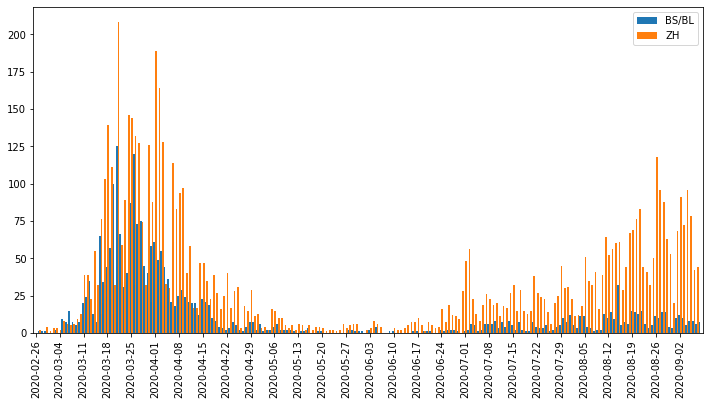

In [6]:
n = 7
specials = newcases.loc[:,['BL', 'BS', 'ZH']]
specials['BS/BL'] = specials['BS'] + specials['BL']
ax = specials.plot(kind='bar', y=['BS/BL','ZH'], width=1)
ticks = ax.xaxis.get_ticklocs()
ticklabels = [l.get_text() for l in ax.xaxis.get_ticklabels()]
ax.xaxis.set_ticks(ticks[::n])
ax.xaxis.set_ticklabels(ticklabels[::n])

ax.figure.show()

In [7]:
LOCKDOWN = '2020-03-20'
PHASE_ONE = '2020-06-06' # 300 personen, bibliothek und schule offen
PHASE_TWO = '2020-06-22' # praktisch keine restriktionen mehr
MASK_OBLIGATION = '2020-07-01'

In [8]:
cm = dict()
for pc in pp.get_children():
    try:
        cm[pc.get_label()] = pc.get_color()
    except AttributeError as ae:
        pass
        #print(ae, pc.__class__.__name__)
#cm

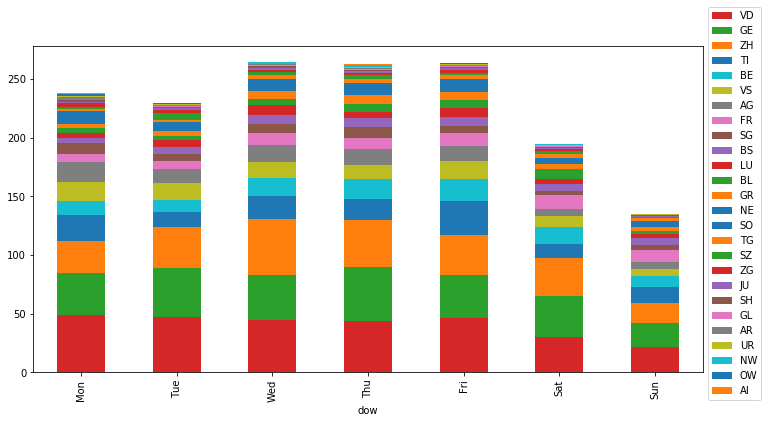

In [9]:
from datetime import datetime as dt
ncstats = newcases.copy()
ncstats['dow'] = [dt.strftime(dt.strptime(f'{date}', '%Y-%m-%d'), '%a') for date in newcases.index]
sorted_columns = [c for c in newcases.sum().sort_values(ascending=False).index if c != 'CH']+['dow']
ncstats_mean = ncstats.loc[:,sorted_columns]\
    .groupby('dow').mean()\
    .loc[[dt.strftime(d, '%a') for d in [dt.strptime(f'{i}', '%d') for i in range(1,8)]]]
ncstats_mean.plot.bar(stacked=True, color=[cm.get(c) for c in sorted_columns]).legend(loc='lower left', bbox_to_anchor=(1, -0.1));

In [10]:
normfactor = ncstats.loc[:,sorted_columns].mean() / ncstats_mean
# TODO: outlier removal
normed_newcases = ncstats.loc[:,['dow']].join(normfactor, on='dow').loc[:,sorted_columns[:-1]] * ncstats.loc[:,sorted_columns[:-1]]

C:\Users\me\Anaconda3\envs\env_climada\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


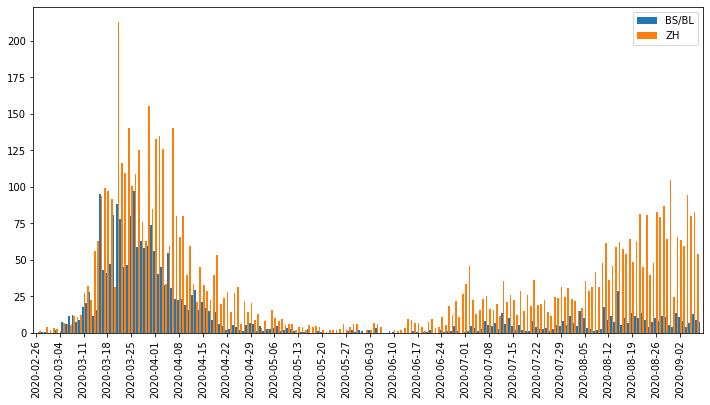

In [11]:
n = 7
normed_specials = normed_newcases.loc[:,['BL', 'BS', 'ZH']]
normed_specials['BS/BL'] = normed_specials['BS'] + normed_specials['BL']
ax = normed_specials.plot(kind='bar', y=['BS/BL','ZH'], width=1)
ticks = ax.xaxis.get_ticklocs()
ticklabels = [l.get_text() for l in ax.xaxis.get_ticklabels()]
ax.xaxis.set_ticks(ticks[::n])
ax.xaxis.set_ticklabels(ticklabels[::n])

ax.figure.show()

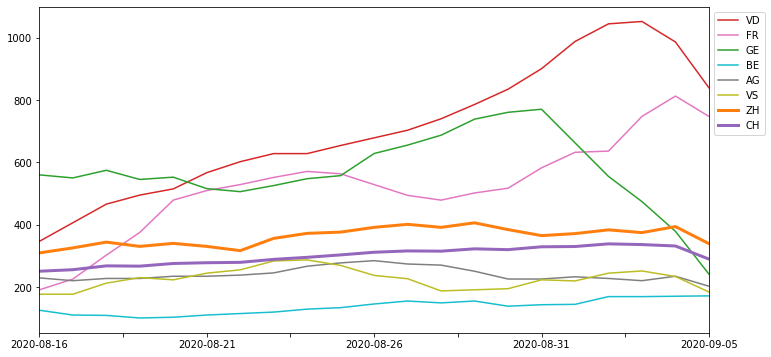

In [12]:
period = 21
critical_period = 3
shown = 8
outstanding = ['ZH', 'CH']

mostaffected = ncit.tail(critical_period).sum().sort_values(ascending=False).head(shown).index
for c in outstanding:
    mostaffected = mostaffected.drop(c)

hf,ax = plt.subplots()

ncit\
    .tail(period)\
    .apply(lambda c: c / cantondata.loc[c.name, 'ratio'])\
    .loc[:,mostaffected]\
    .plot(ax=ax, color=[cm.get(ma) for ma in mostaffected])

ncit\
    .tail(period)\
    .apply(lambda c: c / cantondata.loc[c.name, 'ratio'])\
    .loc[:,outstanding]\
    .plot(ax=ax, color=[cm.get(ma) for ma in outstanding], linewidth=3).legend(loc='upper left', bbox_to_anchor=(1, 1));

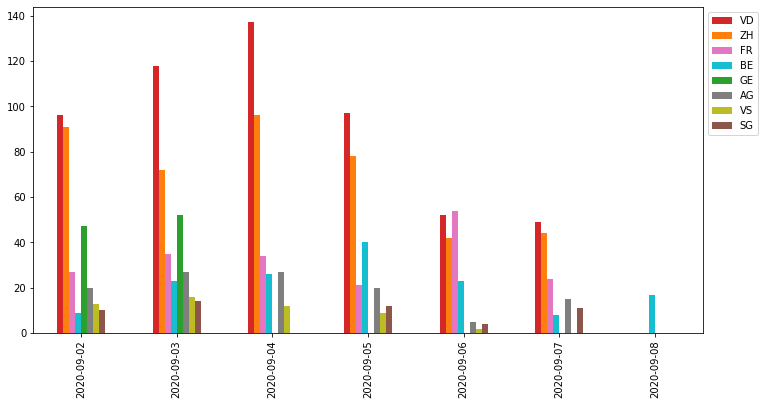

In [13]:
period = 7
critical_period = [5,2] # for selection of cantons. most affected during the last seven days but not considering the last two.
shown = 8

mostaffected = newcases.tail(sum(critical_period)).head(critical_period[0]).sum().map(lambda x: x if x != 0 else None).dropna().sort_values(ascending=False).head(shown+1).index
mostaffected = mostaffected.drop('CH')
colors = [cm.get(ma) for ma in mostaffected]
newcases.tail(period).loc[:,mostaffected].plot.bar(color=colors).legend(loc='upper left', bbox_to_anchor=(1, 1));

In [14]:
! python --version

Python 3.7.3
